<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr />

# <h1 align="center"> Exercise 1: Lasso and Ridge Regression </h1>

<hr />
<center>Constructor Academy, 2024</center>

## Exercise
**Perform Lasso and Ridge regression on california housing  dataset. Visualize the effect of different alpha values on the coefficients**(Hint: The logarithm is your friend!).
- Work first with a random subsample of 500  data points and drop the column “total_bedroom”. (pandas.DataFrame.sample, don't forget to set a random_state for repeatability)  
- Compare the values of coefficients obtained by these two methods with those that you obtain without applying any regularization. Use visuals wherever necessary! <br>
  Remember: It is important to scale the features to a similar scale (Hint: Use a pipeline).
- Show the effect of different alpha values on the coefficients (Hint: Use np.logspace( )).
- Increase the complexity of the model by  adding polynomial features to the pipeline. (you can use sklearn.preprocessing.PolynomialFeatures) Test regularization with different alpha values. Would you expect a stronger or lower effect of regularization for the more complex model?
- Compare the train and test scores from the Ridge and Lasso regression with the train and test scores from the basic Multiple Linear Regression (included polynomial features). Use a plot to visualize the effects of different penalties.
- Investigate the effect of regularization changes when you increase the number of data points. Try 1000, 2000, 5000  and all data points.

**Bonus**
   
   - Apply ElasticNet and compare its result with those from Lasso and Ridge.
   - Repeat the experiment by including the column “total_bedrooms” after imputing missing values. How does this affect the performance of the model?


## Import Libraries and Preprocess the Data

In [1]:
%matplotlib inline
#%load_ext lab_black

In [2]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

In [3]:
plt.rcParams["figure.figsize"] = (8, 8)  # Change matplotlib Box Size
plt.rcParams["font.size"] = 14  # Change matplotlib Font Size
plt.style.use("ggplot")

In [4]:
data_path = "../data/california_housing.csv"

## Load the data 

California Housing dataset [description](https://www.kaggle.com/camnugent/california-housing-prices): 

**Context**:

This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow'. 
It serves as an excellent introduction to implementing machine learning algorithms because it requires rudimentary data cleaning, has an easily understandable list of variables and sits at an optimal size between being to toyish and too cumbersome.

The data contains information from the 1990 California census. 
So although it may not help you with predicting current housing prices, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.

**Content**:  

The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data. Be warned the data aren't cleaned so there are some preprocessing steps required! The columns are as follows, their names are pretty self explanitory:

  - longitude: A measure of how far west a house is; a higher value is farther west

  - latitude: A measure of how far north a house is; a higher value is farther north

  - housing_median_age: Median age of a house within a block; a lower number is a newer building

  - total_rooms: Total number of rooms within a block

  - total_bedrooms:  Total number of bedrooms within a block

  - population: Total number of people residing within a block

  - households:  Total number of households, a group of people residing within a home unit, for a block

  - median_income: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

  - median_house_value: (response)   Median house value for households within a block (measured in US Dollars)

In [5]:
data = pd.read_csv(data_path)

In [6]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [7]:
data.shape

(20640, 9)

In [8]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [9]:
data = data.drop(columns="total_bedrooms")

### Perform Train-Test Split on Housing Data

In [10]:
data_train, data_test = train_test_split(data, test_size=0.33, random_state=42)

In [11]:
data_train.shape, data_test.shape

((13828, 8), (6812, 8))

In [12]:
df_train = data_train.sample(
    n=500, random_state=42
)  # change the argument n as 1000, 2000, 5000 and whole data

# # Select X and y values (predictor and outcome)
X_train = df_train.drop(columns="median_house_value")
y_train = df_train["median_house_value"]

In [13]:
X_test = data_test.drop(columns="median_house_value")
y_test = data_test["median_house_value"]

In [14]:
X_train.shape, X_test.shape

((500, 7), (6812, 7))

## Multiple Linear Regression:
We run MLR first in order to collect score and coefficients of this method to compare with Ridge and Lasso later.

#### Feature Scaling using Pipeline

In [15]:
sc = StandardScaler()
lin_reg = LinearRegression()

pipeline_mlr = Pipeline([("data_scaling", sc), ("estimator", lin_reg)])

#### Fit the Model and Predict

In [16]:
mlin_reg_score_train = cross_val_score(pipeline_mlr, X_train, y_train, cv=3)
mlin_reg_score_train

array([0.58187616, 0.65668264, 0.61751816])

In [17]:
pipeline_mlr.fit(X_train, y_train)

Pipeline(steps=[('data_scaling', StandardScaler()),
                ('estimator', LinearRegression())])

#### Finding Coefficients of Multiple Linear Regression

In [18]:
print(
    pipeline_mlr.named_steps["estimator"].intercept_,
    pipeline_mlr.named_steps["estimator"].coef_,
)

213142.6499999994 [-89818.52257053 -93739.84913757  22669.59213819  13978.33421365
 -60734.15297054  50875.33709886  73691.63779295]


#### Coefficients of Multiple Linear Regression

In [19]:
predictions_mlr = pipeline_mlr.predict(X_test)
coefs_mlr = pd.DataFrame(
    pipeline_mlr.named_steps["estimator"].coef_,
    df_train.columns[:-1],
    columns=["Coefficients"],
)
coefs_mlr

,Coefficients
longitude,-89818.522571
latitude,-93739.849138
housing_median_age,22669.592138
total_rooms,13978.334214
population,-60734.152971
households,50875.337099
median_income,73691.637793


#### Model Evaluation

In [20]:
# Test score
mlin_reg_score = pipeline_mlr.score(X_test, y_test)

# Train score
mlin_reg_score_train = mlin_reg_score_train.mean()

mlin_reg_score, mlin_reg_score_train

(0.6256892677210809, 0.6186923175576123)

In [21]:
print("MAE", metrics.mean_absolute_error(y_test, predictions_mlr))
print("MSE", metrics.mean_squared_error(y_test, predictions_mlr))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, predictions_mlr)))
print("Explained Var Score", metrics.explained_variance_score(y_test, predictions_mlr))

MAE 52435.62511352989
MSE 4988034181.8473015
RMSE 70626.01632434964
Explained Var Score 0.6258648052097011


In [22]:
def score_mlr(X_train, y_train):

    pipeline_mlr = Pipeline([("data_scaling", sc), ("estimator", lin_reg)])

    mlin_reg_score_train_cv = cross_val_score(pipeline_mlr, X_train, y_train, cv=3)
    pipeline_mlr.fit(X_train, y_train)

    # Test score
    mlin_reg_score = pipeline_mlr.score(X_test, y_test)

    # Train score
    mlin_reg_score_train = mlin_reg_score_train_cv.mean()

    return mlin_reg_score, mlin_reg_score_train

In [23]:
score_mlr(X_train, y_train)

(0.6256892677210809, 0.6186923175576123)

### Adding polynomial features to the pipeline.

In [24]:
sc = StandardScaler()
lin_reg = LinearRegression()
poly_feat_2 = PolynomialFeatures(2, include_bias=False)

pipeline_lr = Pipeline(
    [("poly_feat", poly_feat_2),
     ("data_scaling", sc),
     ("estimator", lin_reg)]
)

#### Fit the Model and Predict

In [25]:
lin_reg_score_train_cv = cross_val_score(pipeline_lr, X_train, y_train, cv=3)
lin_reg_score_train_cv

array([0.61612378, 0.69895818, 0.71478119])

In [26]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('poly_feat', PolynomialFeatures(include_bias=False)),
                ('data_scaling', StandardScaler()),
                ('estimator', LinearRegression())])

#### Finding Coefficients of Multiple Linear Regression

In [27]:
print(
    pipeline_lr.named_steps["estimator"].intercept_,
    pipeline_lr.named_steps["estimator"].coef_,
)

213142.6499999769 [-9.33020841e+05 -6.92181525e+05 -1.74343913e+06  4.45089906e+06
 -2.83607517e+04 -3.67484537e+06 -3.19171017e+06 -1.28617971e+06
 -9.94387893e+05 -2.64358049e+06  6.74546106e+06  3.25089847e+05
 -6.00324296e+06 -4.80478844e+06  5.70356942e+04 -9.21189514e+05
  2.12387946e+06  4.48872885e+05 -2.30574360e+06 -1.46227995e+06
  3.49117316e+04 -9.81401421e+02 -1.14924672e+05  1.30994486e+05
 -1.27009968e+04 -1.60140789e+05 -3.38601359e+05  6.40012546e+05
  2.13075807e+05  3.37543985e+05 -2.81587862e+05 -9.66459822e+04
 -1.78331800e+05 -6.85879479e+04 -7.96142780e+04]


#### Coefficients of Multiple Linear Regression

In [28]:
predictions_lr = pipeline_lr.predict(X_test)
coefs_lr = pd.DataFrame(
    pipeline_lr.named_steps["estimator"].coef_,
    columns=["Coefficients"],
)
coefs_lr.head()

,Coefficients
0,-9.330208e+05
1,-6.921815e+05
2,-1.743439e+06
3,4.450899e+06
4,-2.836075e+04


#### Model Evaluation

In [29]:
# Test score
lin_reg_score = pipeline_lr.score(X_test, y_test)

# Train score
lin_reg_score_train = lin_reg_score_train_cv.mean()

lin_reg_score, lin_reg_score_train

(0.5442406357858106, 0.6766210501956587)

In [30]:
print("MAE", metrics.mean_absolute_error(y_test, predictions_lr))
print("MSE", metrics.mean_squared_error(y_test, predictions_lr))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, predictions_lr)))
print("Explained Var Score", metrics.explained_variance_score(y_test, predictions_lr))

MAE 49091.7495288238
MSE 6073411984.6272
RMSE 77932.09855141334
Explained Var Score 0.5452660839679478


In [34]:
def score_lr_poly(X_train, y_train):

    pipeline_lr = Pipeline(
        [("poly_feat", poly_feat_2),
         ("data_scaling", sc),
         ("estimator", lin_reg)]
    )
    lin_reg_score_train_cv = cross_val_score(pipeline_lr, X_train, y_train, cv=3)
    pipeline_lr.fit(X_train, y_train)
    # Test score
    lin_reg_score = pipeline_lr.score(X_test, y_test)

    # Train score
    lin_reg_score_train = lin_reg_score_train_cv.mean()

    return lin_reg_score, lin_reg_score_train

In [35]:
score_lr_poly(X_train, y_train)

(0.5442406357858106, 0.6766210501956587)

## Ridge Regression

Perform Ridge regression.Visualize the effect of different alpha values on the coefficients (Hint: The logarithm is your friend!). 

 - Compare the values of the coefficients obtained with the multiple linear regression coefficients. Use visuals wherever necessary!
   
 - Compare the train and test scores from the Ridge regression with the train and test scores from the basic  Multiple Linear Regression. Use a plot to visualize the effects of different penalties.

In [36]:
# Calculate the effect of different alpha values on the coefficients.
# We declare alphas in log space. It allows us to represent the effect of Ridge regression better.

alphas_log = np.logspace(-5, 6, num=101)
ridge_r = Ridge()
pipeline_r = Pipeline([("data_scaling", sc), ("estimator", ridge_r)])

coefs = []
mse = []
rscore_test = []
rscore_train = []

# Fit Ridge regression for different values of alpha
for a in alphas_log:
    pipeline_r.set_params(estimator__alpha=a)
    score_train_cv = cross_val_score(pipeline_r, X_train, y_train, cv=3)
    pipeline_r.fit(X_train, y_train)
    predictions = pipeline_r.predict(X_test)
    coefs.append(pipeline_r.named_steps["estimator"].coef_)
    mse.append(metrics.mean_squared_error(y_test, predictions))
    rscore_test.append(pipeline_r.score(X_test, y_test))
    rscore_train.append(score_train_cv.mean())

### Visualize the effect of different alpha values on the coefficients. Compare the values of the coefficients obtained by these two methods with the multiple linear regression coefficients. 

In [37]:
ridge_r

Ridge(alpha=1000000.0)

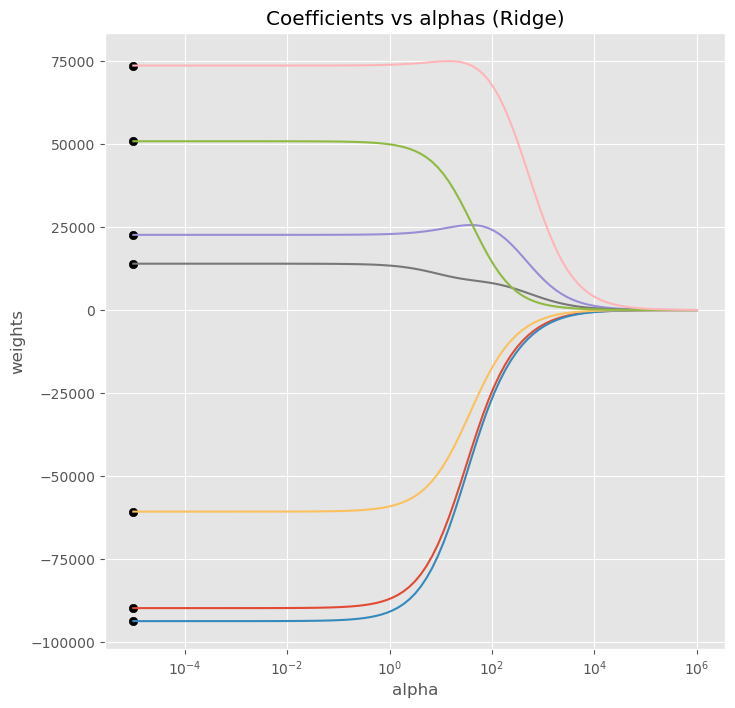

In [38]:
ax = plt.gca()

# plot the Ridge regression coefficients vs different alpha values
ax.plot(alphas_log, coefs)

# plot the Multiple Linear Regression coefficients vs the smallest alpha (ideally alpha == 0 but for visualization purpose we let it be 1e-5).
ax.scatter([alphas_log[0]] * coefs_mlr.shape[0], coefs_mlr, color="black")

ax.set_xscale("log")
plt.title("Coefficients vs alphas (Ridge)")
plt.axis("tight")
plt.xlabel("alpha")
plt.ylabel("weights")
None

The black circles are coefficients of MLR (when $\alpha \approx 0$) and lines with different colors are the coefficients of Ridge regression vs alphas. 

### Compare the train and test scores from the Ridge regression with the train and test scores from the Multiple Linear Regression. 


In [39]:
df = pd.DataFrame(coefs)
df.columns = df.iloc[:, :].columns.values

df.insert(0, "train_score", rscore_train)
df.insert(0, "test_score", rscore_test)
df.insert(0, "mse", mse)
df.insert(0, "alpha", alphas_log)

In [40]:
df.iloc[::5, :]

,alpha,mse,test_score,train_score,0,1,2,3,4,5,6
0,0.000010,4.988034e+09,0.625689,0.618692,-89818.493853,-93739.819792,22669.594736,13978.328007,-60734.136908,50875.327941,73691.640319
5,0.000035,4.988034e+09,0.625689,0.618692,-89818.420678,-93739.745015,22669.601357,13978.312193,-60734.095978,50875.304606,73691.646757
10,0.000126,4.988033e+09,0.625689,0.618692,-89818.161042,-93739.479697,22669.624846,13978.256081,-60733.950755,50875.221809,73691.669599
15,0.000447,4.988031e+09,0.625690,0.618692,-89817.239834,-93738.538330,22669.708190,13978.056995,-60733.435491,50874.928032,73691.750642
20,0.001585,4.988022e+09,0.625690,0.618693,-89813.971441,-93735.198411,22670.003885,13977.350700,-60731.607334,50873.885655,73692.038160
25,0.005623,4.987991e+09,0.625692,0.618695,-89802.376964,-93723.350195,22671.052816,13974.845763,-60725.121696,50870.186936,73693.057904
30,0.019953,4.987882e+09,0.625701,0.618700,-89761.266125,-93681.339600,22674.771605,13965.971642,-60702.121181,50857.060530,73696.670940
35,0.070795,4.987500e+09,0.625729,0.618719,-89615.749788,-93532.637661,22687.929206,13934.657083,-60620.655512,50810.450972,73709.425858
40,0.251189,4.986217e+09,0.625826,0.618774,-89103.805063,-93009.475330,22734.150507,13825.676029,-60333.396068,50644.656410,73753.879324
45,0.891251,4.982513e+09,0.626104,0.618838,-87340.406545,-91207.311059,22892.494058,13464.164478,-59336.209651,50052.255228,73901.959145


#### The test score for Ridge regression  might be higher than that of MLR (due to prevented overfitting)

In [41]:
print(
    "Ridge regression test score is",
    df[df["test_score"] == max(df["test_score"])].test_score.values[0],
)
print("MLR test score is ", mlin_reg_score)

Ridge regression test score is 0.6264222635664776
MLR test score is  0.6256892677210809


#### The train score, however, stays the same and goes down as penalty increases

Text(0, 0.5, 'R2 score')

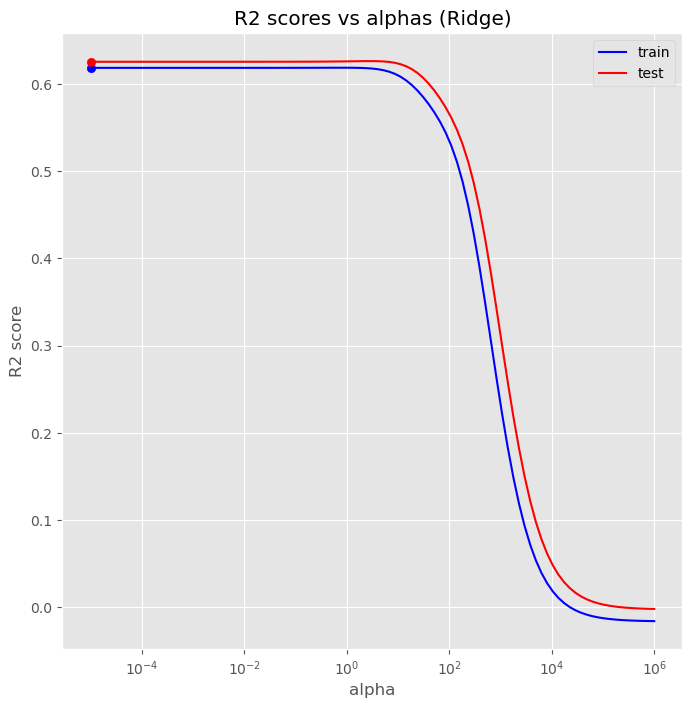

In [42]:
# Let us visualize this effect

# train score
plt.semilogx(df["alpha"], df["train_score"], color="blue", label="train")
plt.scatter(x=alphas_log[0], y=mlin_reg_score_train, color="blue")

# test score
plt.semilogx(df["alpha"], df["test_score"], color="red", label="test")
plt.scatter(x=alphas_log[0], y=mlin_reg_score, color="red")

plt.title("R2 scores vs alphas (Ridge)")
plt.xlabel("alpha")
plt.legend()
plt.ylabel("R2 score")

### Ridge with polynomial features

In [45]:
def ridge_reg(X_train, y_train):
    #     alphas_log = np.logspace(-5, 6, num=101)
    pipeline_r = Pipeline(
        [("poly_feat", poly_feat_2),
         ("data_scaling", sc),
         ("estimator", ridge_r)]
    )
    rscore_test = []
    rscore_train = []

    # Fit Ridge regression for different values of alpha
    for a in alphas_log:
        pipeline_r.set_params(estimator__alpha=a)
        score_train_cv = cross_val_score(pipeline_r, X_train, y_train, cv=3)
        pipeline_r.fit(X_train, y_train)
        predictions = pipeline_r.predict(X_test)
        #     coefs.append(pipeline_r.named_steps["estimator"].coef_)
        #     mse.append(metrics.mean_squared_error(y_test, predictions))
        rscore_test.append(pipeline_r.score(X_test, y_test))
        rscore_train.append(score_train_cv.mean())
    return rscore_train, rscore_test

## Lasso Regression

Perform Lasso regression Visualize the effect of different alpha values on the coefficients (Hint: The logarithm is your friend!). 
 
 - Compare the values of the coefficients obtained with the basic multiple linear regression coefficients. Use visuals wherever necessary!  
 - Compare the train and test scores from the Lasso regression with the train and test scores from the Multiple Linear Regression. Use a plot to visualize the effects of different penalties.

In [46]:
# Calculate the effect of different alpha values on the coefficients.
# We declare alphas in log space. It allows us to represent the effect of Lasso regression better.

alphas_log = np.logspace(-5, 6, num=101)
lasso_r = Lasso(max_iter=1000)

pipeline_l = Pipeline([("data_scaling", sc), ("estimator", lasso_r)])

coefs = []
mse = []
rscore_test = []
rscore_train = []

# Fit Ridge regression for different values of alpha
for a in alphas_log:
    pipeline_l.set_params(estimator__alpha=a)
    score_train_cv = cross_val_score(pipeline_l, X_train, y_train, cv=3)

    pipeline_l.fit(X_train, y_train)
    predictions = pipeline_l.predict(X_test)
    coefs.append(pipeline_l.named_steps["estimator"].coef_)
    mse.append(metrics.mean_squared_error(y_test, predictions))
    rscore_test.append(pipeline_l.score(X_test, y_test))
    rscore_train.append(score_train_cv.mean())

### Visualize the effect of different alpha values on the coefficients. Compare the values of the coefficients obtained by these two methods with the multiple linear regression coefficients.

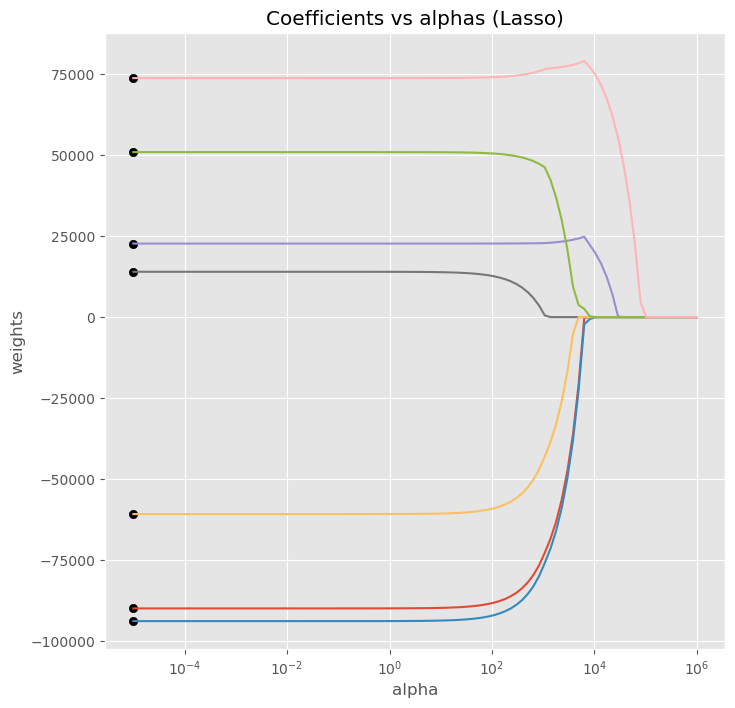

In [47]:
ax = plt.gca()

# plot the Lasso regression coefficients vs different alpha values
ax.plot(alphas_log, coefs)

# plot the Multiple Linear Regression coefficients vs the smallest alpha (ideally alpha == 0 but for visualization purpose we let it be 1e-5).
ax.scatter([alphas_log[0]] * coefs_mlr.shape[0], coefs_mlr, color="black")

ax.set_xscale("log")
plt.title("Coefficients vs alphas (Lasso)")
plt.axis("tight")
plt.xlabel("alpha")
plt.ylabel("weights")
None

### Compare the train and test scores from the Lasso regression with the train and test scores from the Multiple Linear Regression. 


In [48]:
df = pd.DataFrame(coefs)
# df.columns = data.iloc[:, :-1].columns.values

df.insert(0, "train_score", rscore_train)
df.insert(0, "test_score", rscore_test)
df.insert(0, "mse", mse)
df.insert(0, "alpha", alphas_log)

In [49]:
df.iloc[::5, :]

,alpha,mse,test_score,train_score,0,1,2,3,4,5,6
0,0.000010,4.988034e+09,0.625689,0.618692,-89818.522408,-93739.848968,22669.592140,13978.334086,-60734.152807,50875.337059,73691.637819
5,0.000035,4.988034e+09,0.625689,0.618692,-89818.521993,-93739.848536,22669.592144,13978.333761,-60734.152391,50875.336958,73691.637887
10,0.000126,4.988034e+09,0.625689,0.618692,-89818.520522,-93739.847003,22669.592157,13978.332607,-60734.150914,50875.336600,73691.638127
15,0.000447,4.988034e+09,0.625689,0.618692,-89818.515301,-93739.841560,22669.592207,13978.328510,-60734.145675,50875.335333,73691.638978
20,0.001585,4.988034e+09,0.625689,0.618692,-89818.496767,-93739.822244,22669.592381,13978.313969,-60734.127094,50875.330849,73691.642000
25,0.005623,4.988034e+09,0.625689,0.618692,-89818.431120,-93739.753812,22669.592994,13978.262473,-60734.061056,50875.314744,73691.652697
30,0.019953,4.988032e+09,0.625689,0.618692,-89818.197974,-93739.510801,22669.595182,13978.079568,-60733.826972,50875.257995,73691.690701
35,0.070795,4.988027e+09,0.625690,0.618692,-89817.370442,-93738.648288,22669.602963,13977.430312,-60732.996752,50875.057229,73691.825614
40,0.251189,4.988010e+09,0.625691,0.618692,-89814.433275,-93735.587082,22669.630612,13975.125544,-60730.052199,50874.347045,73692.304559
45,0.891251,4.987948e+09,0.625696,0.618692,-89804.009213,-93724.723089,22669.728751,13966.943527,-60719.608067,50871.834650,73694.004803


#### The test score for Lasso regression  might be higher than that of MLR (due to prevented overfitting)

In [50]:
print(
    "Lasso regression test score is",
    df[df["test_score"] == max(df["test_score"])].test_score.values[0],
)
print("MLR test score is ", mlin_reg_score)

Lasso regression test score is 0.6278966308334196
MLR test score is  0.6256892677210809


#### The train and test scores for Lasso regression

Text(0, 0.5, 'R2 score')

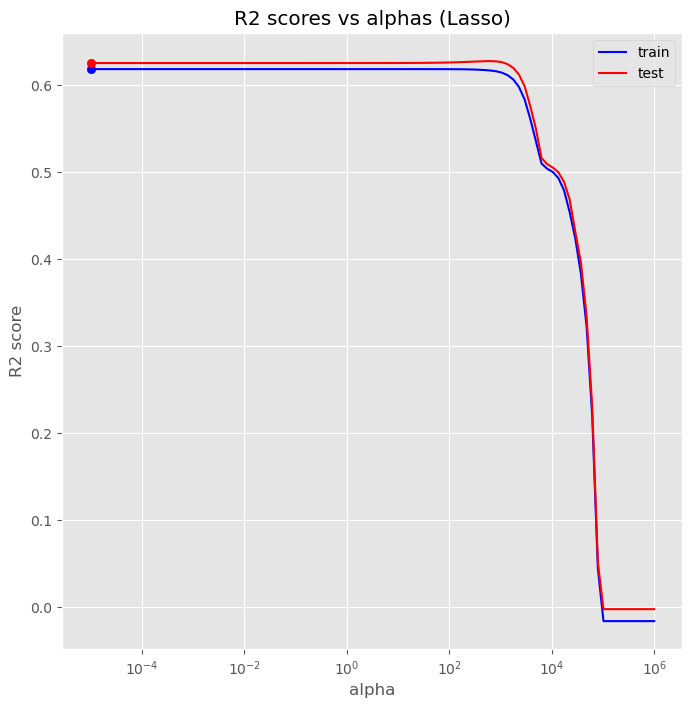

In [51]:
# Let us visualize this effect

# train score
plt.semilogx(df["alpha"], df["train_score"], color="blue", label="train")
plt.scatter(x=alphas_log[0], y=mlin_reg_score_train, color="blue")

# test score
plt.semilogx(df["alpha"], df["test_score"], color="red", label="test")
plt.scatter(x=alphas_log[0], y=mlin_reg_score, color="red")

plt.title("R2 scores vs alphas (Lasso)")
plt.xlabel("alpha")
plt.legend()
plt.ylabel("R2 score")

### Lasso with polynomial features

In [52]:
def lasso_reg(X_train, y_train):
    #     alphas_log = np.logspace(-5, 6, num=101)
    pipeline_l = Pipeline(
        [
            ("poly_feat", poly_feat_2),
            ("data_scaling", sc),
            ("estimator", Lasso(max_iter=1000)),
        ]
    )
    rscore_test = []
    rscore_train = []

    # Fit Lasso regression for different values of alpha
    for a in alphas_log:
        pipeline_l.set_params(estimator__alpha=a)
        # for some values of alpha, convergence is not reached, so we deactivate the convergence warning locally.
        # following example of sklearn: https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore", category=ConvergenceWarning, module="sklearn"
            )
            score_train_cv = cross_val_score(pipeline_l, X_train, y_train, cv=3)

            pipeline_l.fit(X_train, y_train)
        predictions = pipeline_l.predict(X_test)
        coefs.append(pipeline_l.named_steps["estimator"].coef_)
        mse.append(metrics.mean_squared_error(y_test, predictions))
        rscore_test.append(pipeline_l.score(X_test, y_test))
        rscore_train.append(score_train_cv.mean())
    return rscore_train, rscore_test

### Plots lasso and ridge vs Basic MLR

In [53]:
def plot_lasso_ridge(
    ridge_rscore_train,
    ridge_rscore_test,
    lasso_rscore_train,
    lasso_rscore_test,
    lin_reg_score,
    lin_reg_score_train,
):

    # Let us visualize this effect
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # train score
    ax1.semilogx(alphas_log, ridge_rscore_train, color="blue", label="train")
    ax1.scatter(x=alphas_log[0], y=lin_reg_score_train, color="blue")

    # test score
    ax1.semilogx(alphas_log, ridge_rscore_test, color="red", label="test")
    ax1.scatter(x=alphas_log[0], y=lin_reg_score, color="red")

    ax1.set_title("R2 scores vs alphas (Ridge)")
    ax1.set_xlabel("alpha")
    ax1.legend()
    ax1.set_ylabel("R2 score")

    # train score
    ax2.semilogx(alphas_log, lasso_rscore_train, color="blue", label="train")
    ax2.scatter(x=alphas_log[0], y=lin_reg_score_train, color="blue")

    # test score
    ax2.semilogx(alphas_log, lasso_rscore_test, color="red", label="test")
    ax2.scatter(x=alphas_log[0], y=lin_reg_score, color="red")

    ax2.set_title("R2 scores vs alphas (Lasso)")
    ax2.set_xlabel("alpha")
    ax2.legend()
    ax2.set_ylabel("R2 score")

    return plt.show()

## Compare different experiments

In [54]:
def mlr_vs_lasso_ridge(train_data):
    # Select X and y values (predictor and outcome)
    X_train = train_data.drop(columns="median_house_value")
    y_train = train_data["median_house_value"]

    lin_reg_score, lin_reg_score_train = score_lr_poly(X_train, y_train)

    alphas_log = np.logspace(-5, 6, num=101)

    lasso_rscore_train, lasso_rscore_test = lasso_reg(X_train, y_train)
    ridge_rscore_train, ridge_rscore_test = ridge_reg(X_train, y_train)

    plot_lasso_ridge(
        ridge_rscore_train,
        ridge_rscore_test,
        lasso_rscore_train,
        lasso_rscore_test,
        lin_reg_score,
        lin_reg_score_train,
    )

### With Polynomial Features

### 500 datapoints

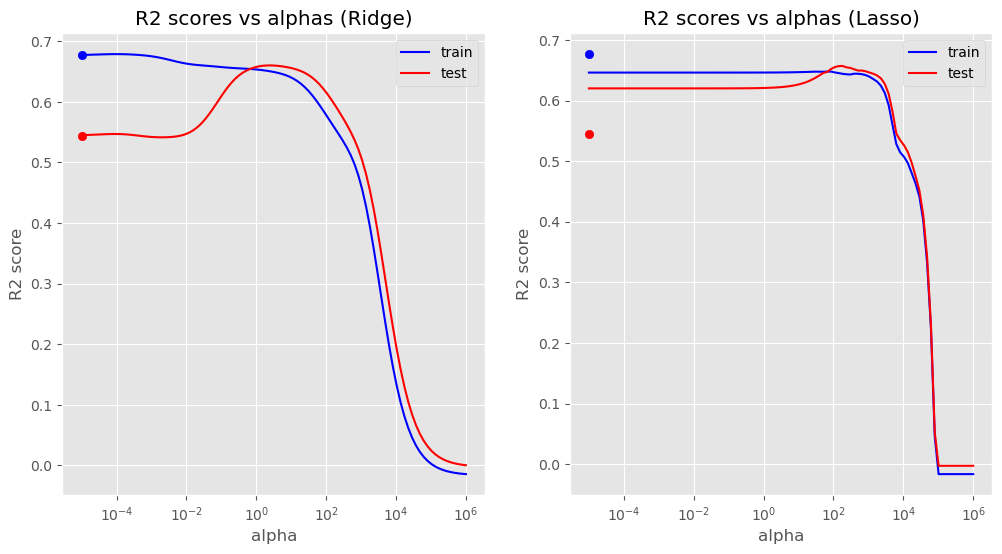

In [55]:
train_data = data_train.sample(
    n=500, random_state=42
)  # change the argument n as 1000, 2000, 5000 and whole data

mlr_vs_lasso_ridge(train_data)

### 1000 datapoints

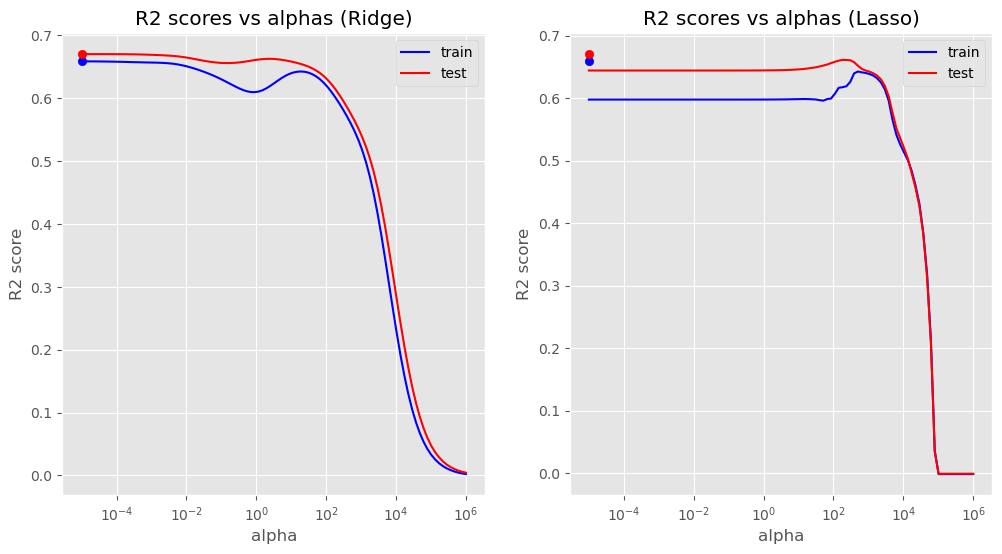

In [56]:
train_data = data_train.sample(
    n=1000, random_state=42
)  # change the argument n as 1000, 2000, 5000 and whole data

mlr_vs_lasso_ridge(train_data)

### 2000 datapoints


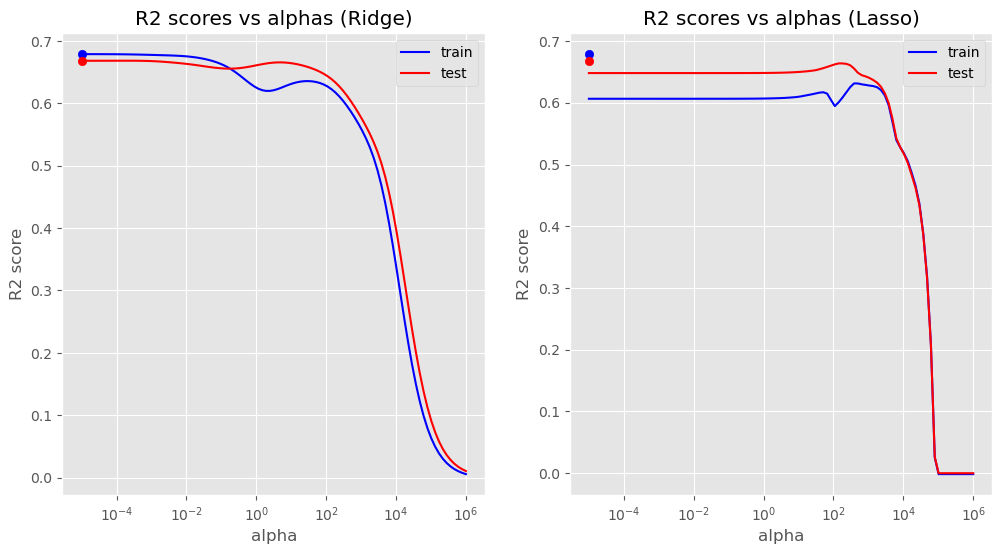

In [57]:
train_data = data_train.sample(
    n=2000, random_state=42
)  # change the argument n as 1000, 2000, 5000 and whole data

mlr_vs_lasso_ridge(train_data)

### 5000 datapoints


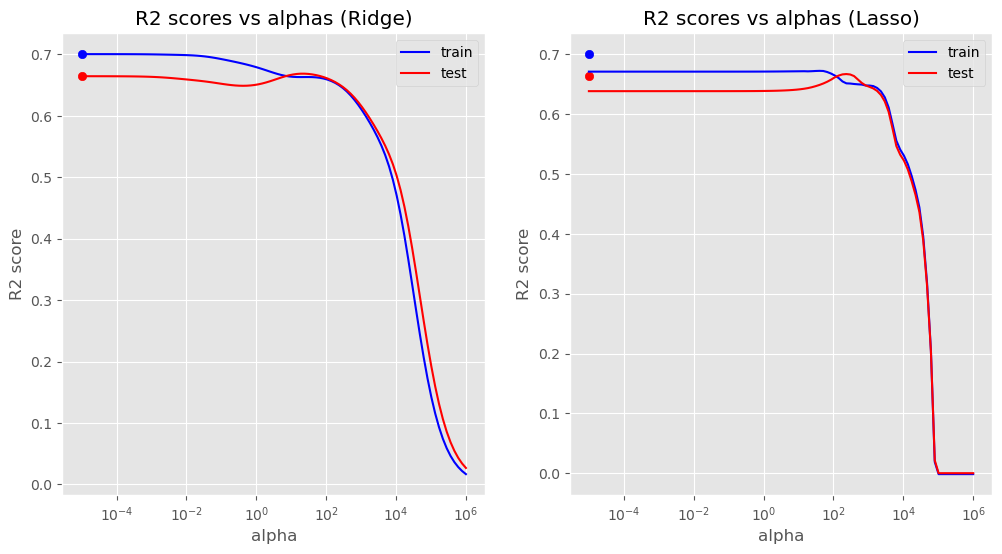

In [58]:
train_data = data_train.sample(
    n=5000, random_state=42
)  # change the argument n as 1000, 2000, 5000 and whole data

mlr_vs_lasso_ridge(train_data)

### Full datapoints



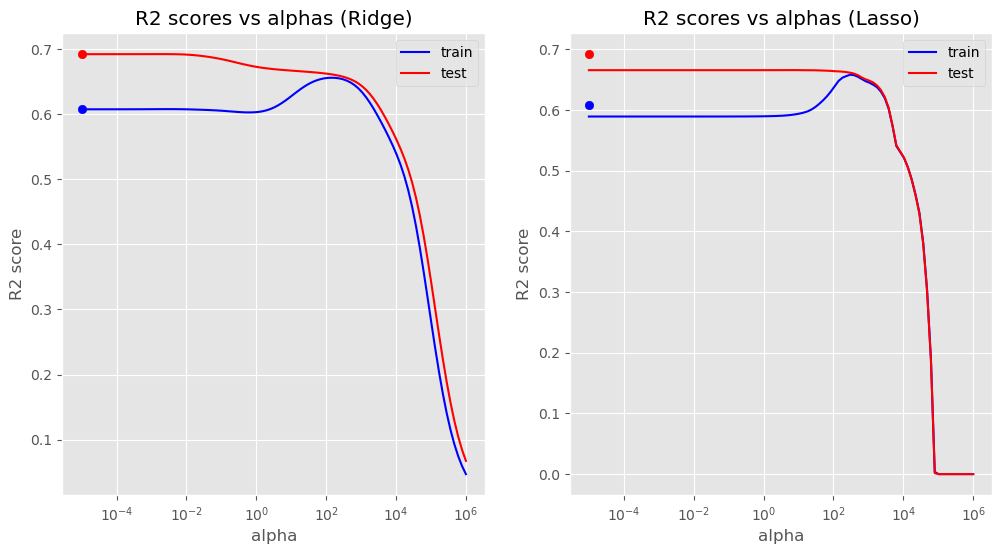

In [59]:
train_data = data_train

mlr_vs_lasso_ridge(train_data)

--------------
# End of This Notebook